# **Read Crema Dataset:**

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import os
import statistics
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/kaggle'
#%cd /content/drive/MyDrive/kaggle
#! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
#ls
#!unzip \*.zip && rm *.zip

In [ ]:
crema_path='/content/drive/MyDrive/kaggle/Crema/'

In [ ]:
sounds = []
labels = []
sampling_rates=[]

#labels_dict = {
#  'SAD': 1,
#  'ANG': 2,
#  'DIS': 3,
#  'FEA':4,
#  'HAP':5,
#  'NEU':6
#}
for dirname, _, filenames in os.walk(crema_path):
    for filename in filenames:

        label = filename[9:12]
        sound,rate =librosa.load(crema_path+filename)

        labels.append(label)
        sounds.append(sound)
        sampling_rates.append(rate)
print(len(sounds))

7442


In [ ]:
print(labels[0])
print(labels[15])
print(labels[25])
print(labels[205])





HAP
HAP
SAD
DIS


**ُencode labels**

In [ ]:
labels = np.array(labels)
le = LabelEncoder()
labels = to_categorical(le.fit_transform(labels))
print(labels.shape)

(7442, 6)


In [ ]:
print(labels[0])
print(labels[15])
print(labels[25])
print(labels[205])

[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0.]


In [ ]:
print(len(sounds[0]))
print(labels[25])
print(len(labels))

47823
[0. 0. 0. 0. 0. 1.]
7442


In [ ]:
def plot_wave(index):
  #print(labels[index])
  plt.figure(figsize=(15, 5))
  librosa.display.waveshow(sounds[index], sr=sampling_rates[index])

def play_sound(index):
  return ipd.Audio(sounds[index],rate=sampling_rates[index])



In [ ]:
play_sound(0)

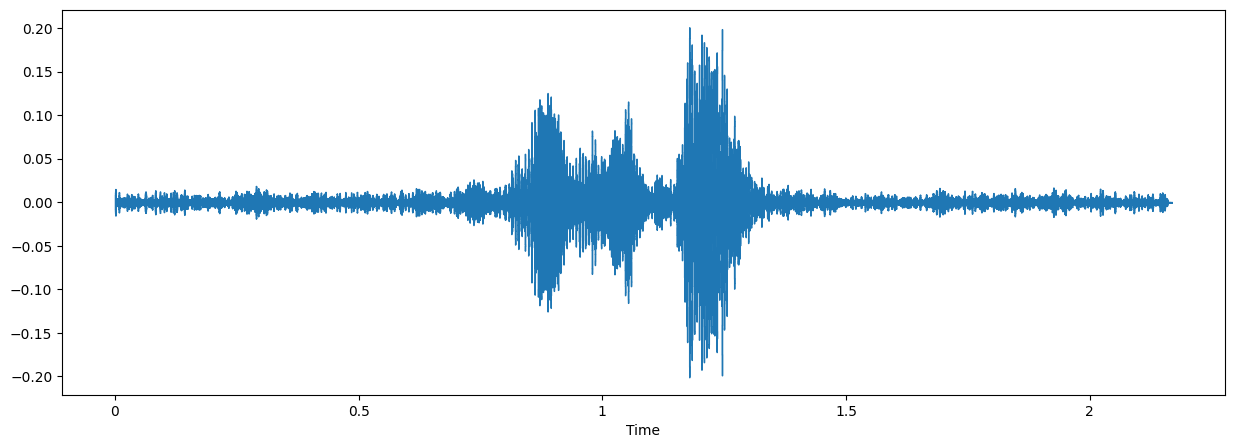

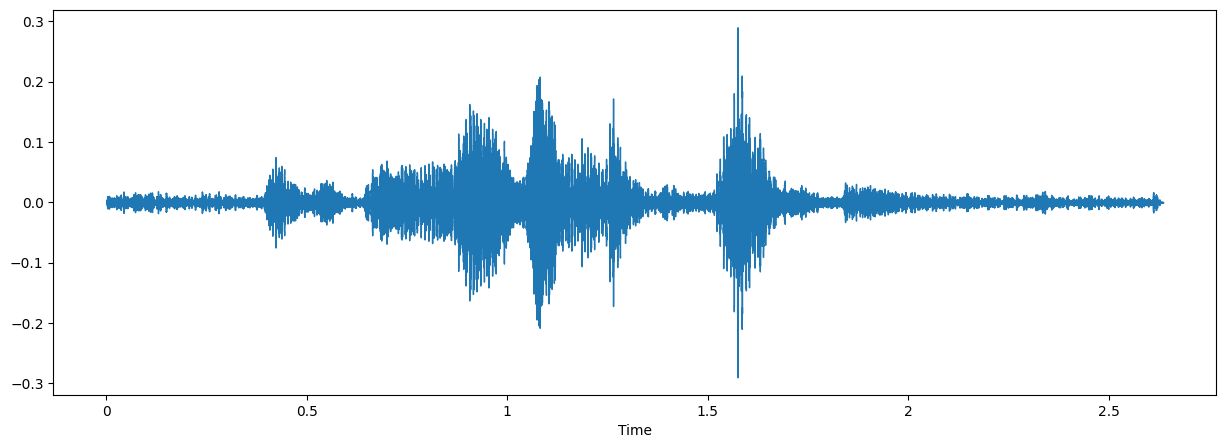

In [ ]:
plot_wave(0)
plot_wave(15)

# **Create Feature Space:**

In [ ]:
#make sure each audio has the same length by padding short audio by 0's or cut long audios

standard_len = math.floor(statistics.mean(map(lambda audio: len(audio) , sounds)))
audios_afterpad=[]
def add_padding():

  for i in range(len(sounds)):
    if len(sounds[i])>standard_len:
        max_offset = len(sounds[i])-standard_len
        offset = np.random.randint(max_offset)
        sound = (sounds[i])[offset:(standard_len+offset)]
    else:
        if standard_len > len(sounds[i]): #if length < required length, add padding
            max_offset = standard_len - len(sounds[i])
            offset = np.random.randint(max_offset)
        else:  #if equal, do nothing, offset = 0
            offset = 0
        sound = np.pad(sounds[i], (offset, standard_len - len(sounds[i]) - offset), "constant")

    audios_afterpad.append(sound)
add_padding()
print(len(audios_afterpad))

7442


**Create feature Space 1 :**

In [ ]:
data_matrix1 = []
FRAME_SIZE = 1024
HOP_LENGTH = 512
def create_D1():

  for signal in audios_afterpad:
        rms = librosa.feature.rms(y=signal)[0]
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        arr = np.hstack((rms,zcr))
        arr = arr.reshape((arr.shape[0], 1))
        data_matrix1.append(arr)

create_D1()


In [ ]:
data_matrix1=np.array(data_matrix1)
print(data_matrix1.shape)

(7442, 220, 1)


**Convert audio form into melspectogram**

In [ ]:
data_matrix2 = []
def create_D2():
  for audio in audios_afterpad:
    S = librosa.feature.melspectrogram(y=audio, sr=16000)
    S_DB = librosa.power_to_db(S, ref=np.max,top_db=80)
    data_matrix2.append(S_DB)
create_D2()

In [ ]:
data_matrix2=np.array(data_matrix2)

print(data_matrix2.shape)

(7442, 128, 110)


**split data:**

In [ ]:
def split_data(data_mat,data_labels,split_size):
  x_train, x_test , y_train , y_test = train_test_split(data_mat, data_labels, test_size=split_size, random_state=42, stratify=data_labels)
  return np.array(x_train) ,np.array(y_train), np.array(x_test), np.array(y_test)



In [ ]:

#Split the data into 70->train&valid and 30->testing
X_train_d1, y_train_d1, X_test_d1 , y_test_d1 = split_data(data_matrix1 ,labels ,0.3)

#validation data
X_train_d1,  y_train_d1 ,X_validation_d1 , y_validation_d1 = split_data(X_train_d1,y_train_d1 ,0.05)

In [ ]:

#Split the data into 70->train&valid and 30->testing
X_train_d2, y_train_d2, X_test_d2 , y_test_d2 = split_data(data_matrix2 ,labels ,0.3)

#validation data
X_train_d2,  y_train_d2 ,X_validation_d2 , y_validation_d2 = split_data(X_train_d2,y_train_d2 ,0.05)

In [ ]:
print(X_train_d1.shape, y_train_d1.shape, X_test_d1.shape, y_test_d1.shape, X_validation_d1.shape, y_validation_d1.shape)
print(X_train_d2.shape, y_train_d2.shape, X_test_d2.shape, y_test_d2.shape, X_validation_d2.shape, y_validation_d2.shape)


(4948, 220, 1) (4948, 6) (2233, 220, 1) (2233, 6) (261, 220, 1) (261, 6)
(4948, 128, 110) (4948, 6) (2233, 128, 110) (2233, 6) (261, 128, 110) (261, 6)


# **1D_Convolution**

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.python.framework import ops

In [ ]:
#vgg 16 model

def one_d_convolution(input_dimensions):

  input_layer = tf.keras.Input(shape=input_dimensions)

  c_1 = tfl.Conv1D(64,3, activation='relu', padding="same", strides=1)(input_layer)
  c_2 = tfl.Conv1D(64,3, activation='relu', padding="same", strides=1)(c_1)
  p_1 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_2)

  c_3 = tfl.Conv1D(128,3, activation='relu', padding="same", strides=1)(p_1)
  c_4 = tfl.Conv1D(128,3, activation='relu', padding="same", strides=1)(c_3)
  p_2 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_4)

  c_5 = tfl.Conv1D(256,3, activation='relu', padding="same", strides=1)(p_2)
  c_6 = tfl.Conv1D(256,3, activation='relu', padding="same", strides=1)(c_5)
  p_3 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_6)

  c_8 = tfl.Conv1D(512,3, activation='relu', padding="same", strides=1)(p_3)
  c_9 = tfl.Conv1D(512,3, activation='relu', padding="same", strides=1)(c_8)
  c_10 = tfl.Conv1D(512,3, activation='relu', padding="same", strides=1)(c_9)
  p_4 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_10)

  c_12 = tfl.Conv1D(512,3, activation='relu', padding="same", strides=1)(p_4)
  c_13 = tfl.Conv1D(512,3, activation='relu', padding="same", strides=1)(c_12)
  c_14 = tfl.Conv1D(512,3, activation='relu', padding="same", strides=1)(c_13)
  p_5 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_14)

  flat = tfl.Flatten()(p_5)

  d_1 = tfl.Dense(4096, activation='relu')(flat)
  d_2 = tfl.Dense(4096, activation='relu')(d_1)
  d_3 = tfl.Dense(1000, activation='relu')(d_2)

  output_layer = tfl.Dense(6, activation='softmax')(d_3)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  return model

In [ ]:
def one_d_convolution(input_dimensions):

    input_layer = tf.keras.Input(shape=input_dimensions)

    c_3 = tfl.Conv1D(64, 3, activation='relu', padding="same", strides=1)(input_layer)
    c_4 = tfl.Conv1D(64, 3, activation='relu', padding="same", strides=1)(c_3)
    p_2 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_4)

    c_5 = tfl.Conv1D(128, 3, activation='relu', padding="same", strides=1)(p_2)
    c_6 = tfl.Conv1D(128, 3, activation='relu', padding="same", strides=1)(c_5)
    p_3 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_6)

    c_7 = tfl.Conv1D(256, 3, activation='relu', padding="same", strides=1)(p_3)
    p_4 = tfl.MaxPool1D(pool_size=5, strides=2, padding="same")(c_7)

    c_8 = tfl.Conv1D(512, 3, activation='relu', padding="same", strides=1)(p_4)
    p_5 = tfl.MaxPool1D(pool_size=2, strides=2, padding="same")(c_8)

    f_1 = tfl.Flatten()(p_4)

    d_1 = tfl.Dense(1024, activation='relu')(f_1)

    drop_1 = tfl.Dropout(0.2)(d_1)

    output_layer = tfl.Dense(6, activation='softmax')(drop_1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
oneD_conv = one_d_convolution((220, 1))
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
oneD_conv.compile(optimizer=optimiser, loss='categorical_crossentropy',
                  metrics=['accuracy'])
oneD_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 220, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 220, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 110, 128)          24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 110, 128)          49280     
                                                             

In [ ]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

checkpoint_filepath = '/tmp/checkpoint5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

In [ ]:
history = oneD_conv.fit(X_train_d1, y_train_d1, epochs=20, validation_data=(X_validation_d1 , y_validation_d1))

Epoch 1/20
155/155 [==============================] - 16s 14ms/step - loss: 1.6090 - accuracy: 0.3147 - val_loss: 1.4797 - val_accuracy: 0.3640
Epoch 2/20
155/155 [==============================] - 1s 8ms/step - loss: 1.4641 - accuracy: 0.3941 - val_loss: 1.4276 - val_accuracy: 0.4100
Epoch 3/20
155/155 [==============================] - 1s 8ms/step - loss: 1.4248 - accuracy: 0.4234 - val_loss: 1.4049 - val_accuracy: 0.4330
Epoch 4/20
155/155 [==============================] - 1s 7ms/step - loss: 1.3952 - accuracy: 0.4422 - val_loss: 1.3776 - val_accuracy: 0.4368
Epoch 5/20
155/155 [==============================] - 1s 7ms/step - loss: 1.3770 - accuracy: 0.4517 - val_loss: 1.3888 - val_accuracy: 0.4138
Epoch 6/20
155/155 [==============================] - 1s 7ms/step - loss: 1.3608 - accuracy: 0.4515 - val_loss: 1.3515 - val_accuracy: 0.4483
Epoch 7/20
155/155 [==============================] - 1s 6ms/step - loss: 1.3408 - accuracy: 0.4523 - val_loss: 1.3515 - val_accuracy: 0.4636
Epoc

In [ ]:
score = oneD_conv.evaluate(X_test_d1, y_test_d1)

70/70 [==============================] - 0s 5ms/step - loss: 1.2811 - accuracy: 0.5052


# **2D_Convolution**

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D ,MaxPooling1D ,MaxPooling2D , Conv1D
from keras.callbacks import ModelCheckpoint
from datetime import datetime

In [ ]:
def TwoD_convolutional_model(InputDimension):

  CNNmodel =Sequential()
  CNNmodel.add(Conv2D(filters=16, kernel_size=3, input_shape=InputDimension, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Conv2D(filters=32, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Conv2D(filters=64, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Flatten())
  CNNmodel.add(Dense(512, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(256, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(128, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(6, activation='softmax'))
  return CNNmodel;


In [ ]:
def TwoD_convolutional_model(InputDimension):
  CNNmodel =Sequential()

  CNNmodel.add(Conv2D(filters=16, kernel_size=3, input_shape=InputDimension, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2 ,strides=2))


  CNNmodel.add(Conv2D(filters=32, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2 ,strides=2))


  CNNmodel.add(Conv2D(filters=64, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2 ,strides=2))
  CNNmodel.add(Dropout(0.2))


  CNNmodel.add(Conv2D(filters=128, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2 ,strides=2))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Conv2D(filters=256, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2 ,strides=2))
  CNNmodel.add(Dropout(0.2))


  CNNmodel.add(Flatten())
  CNNmodel.add(Dense(512, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(256, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(128, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(6, activation='softmax'))
  return CNNmodel;




In [ ]:
def TwoD_convolutional_model(InputDimension):

  CNNmodel =Sequential()
  CNNmodel.add(Conv2D(filters=64, kernel_size=3, input_shape=InputDimension, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Conv2D(filters=128, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=2))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Conv2D(filters=256, kernel_size=3, activation='relu', strides=1))
  CNNmodel.add(MaxPooling2D(pool_size=5))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Flatten())

  CNNmodel.add(Dense(256, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(128, activation='relu'))
  CNNmodel.add(Dropout(0.2))

  CNNmodel.add(Dense(6, activation='softmax'))
  return CNNmodel;


In [ ]:
Input=(X_train_d2.shape[1],X_train_d2.shape[2],1);  #rows,cols,channels
MODEL = TwoD_convolutional_model(Input)
# Compile the model
MODEL.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary
MODEL.summary()

# Calculate pre-training accuracy
test_loss, test_acc= MODEL.evaluate(X_test_d2, y_test_d2, verbose=0)
accuracy = 100*test_acc

print("Pre-training accuracy: %.4f%%" % accuracy)

# train model
history = MODEL.fit(X_train_d2, y_train_d2, validation_data=(X_validation_d2, y_validation_d2), batch_size=32, epochs=30)

# evaluate model after traiig on test set
test_loss, test_acc = MODEL.evaluate(X_test_d2, y_test_d2, verbose=0)
accuracy = 100*test_acc
print('\nTest accuracy:', accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 108, 64)      640       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 54, 64)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 54, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 52, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 30, 26, 128)      0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 30, 26, 128)      

# **Evaluation**

In [ ]:
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

target_names = ["SAD","ANG","DIS","FEA","HAP","NEU"]

In [ ]:


predicted_labels = oneD_conv.predict(X_test_d1)
predicted_labels = np.argmax(predicted_labels, axis=1)
y_groud_truth = np.argmax(y_test_d1, axis=1)

print(classification_report(y_groud_truth, predicted_labels, target_names=target_names))

f1 = f1_score(y_groud_truth, predicted_labels,average='weighted')
print('F1 score: %f' % f1)

70/70 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         SAD       0.67      0.72      0.69       381
         ANG       0.48      0.48      0.48       382
         DIS       0.41      0.30      0.34       381
         FEA       0.47      0.42      0.45       381
         HAP       0.48      0.50      0.49       326
         NEU       0.48      0.61      0.54       382

    accuracy                           0.51      2233
   macro avg       0.50      0.51      0.50      2233
weighted avg       0.50      0.51      0.50      2233

F1 score: 0.498877


[[275  23  16  47  15   5]
 [ 33 184  37  32  25  71]
 [ 37  43 113  50  37 101]
 [ 60  37  54 160  48  22]
 [  3  44  29  33 164  53]
 [  4  50  30  16  50 232]]


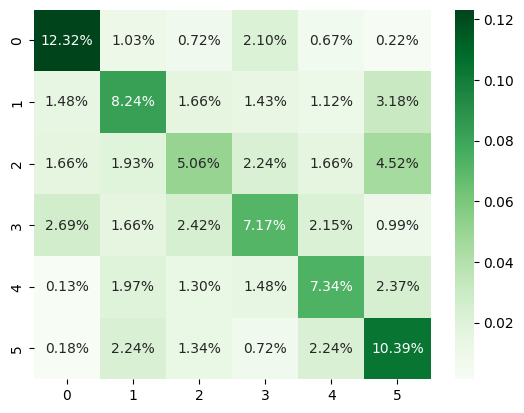

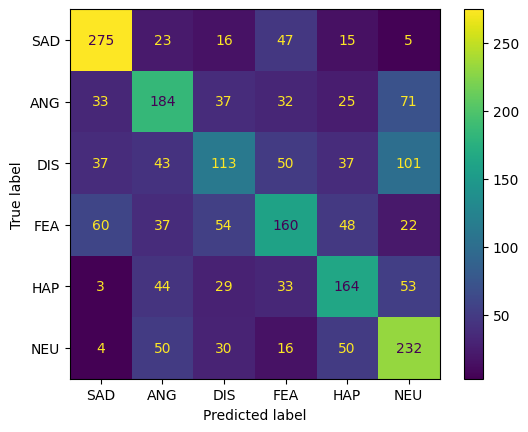

In [ ]:


matrix = confusion_matrix(y_groud_truth, predicted_labels)
print(matrix)
ax = sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Greens')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_groud_truth, predicted_labels,labels=[0,1,2,3,4,5]),
                              display_labels=target_names)
disp = disp.plot()

plt.show()

Second feature space evaluation after 2D_CNN model


In [ ]:
from sklearn.metrics import classification_report, f1_score

predicted_labels_2D = MODEL.predict(X_test_d2)
predicted_labels_2D = np.argmax(predicted_labels_2D, axis=1)
y_groud_truth_2D = np.argmax(y_test_d2, axis=1)

print(classification_report(y_groud_truth_2D, predicted_labels_2D, target_names=target_names))

f1_2D = f1_score(y_groud_truth_2D, predicted_labels_2D,average='weighted')
print('\nTest accuracy:', accuracy/100)
print('F1 score: %f' % f1_2D)

70/70 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

         SAD       0.73      0.60      0.66       381
         ANG       0.44      0.42      0.43       382
         DIS       0.51      0.39      0.44       381
         FEA       0.50      0.61      0.55       381
         HAP       0.52      0.64      0.57       326
         NEU       0.48      0.48      0.48       382

    accuracy                           0.52      2233
   macro avg       0.53      0.53      0.52      2233
weighted avg       0.53      0.52      0.52      2233


Test accuracy: 0.5226153135299683
F1 score: 0.521289


[[230  45  12  75  14   5]
 [ 31 161  24  49  49  68]
 [ 13  51 149  61  24  83]
 [ 38  33  39 234  24  13]
 [  2  33  15  36 209  31]
 [  3  45  53  16  81 184]]


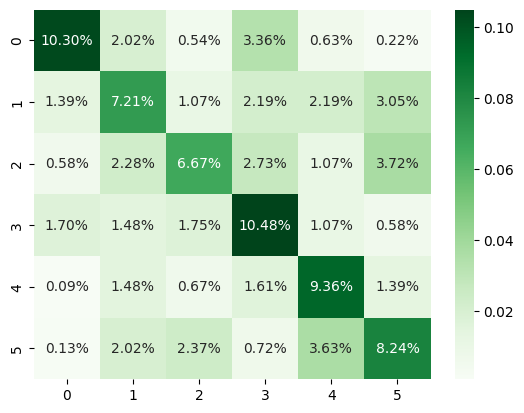

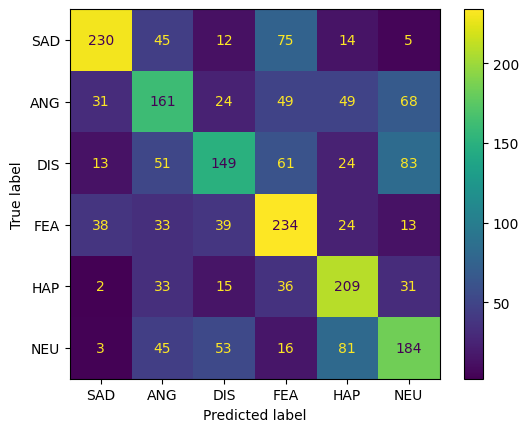

In [ ]:
matrix_2D = confusion_matrix(y_groud_truth_2D, predicted_labels_2D)
print(matrix_2D)
ax = sns.heatmap(matrix_2D/np.sum(matrix_2D), annot=True, fmt='.2%', cmap='Greens')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_groud_truth_2D, predicted_labels_2D,labels=[0,1,2,3,4,5]),
                              display_labels=target_names)
disp = disp.plot()

plt.show()